In [1]:

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np


from torchviz import make_dot, make_dot_from_trace

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

### Select Device ( GPU or CPU)
we will select device. there are two options: GPU or CPU. GPU technology is so faster than CPU technology. We will select GPU device. If your System is not include GPU technology, our function select CPU device.



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Hyper Parameters
Hyper Parameters change each network and there is no rule to select hyper parameters. so we select most uses variable.

In [3]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

###  Define Dataset

In [4]:
train_dataset = torchvision.datasets.MNIST(root='../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

### Data Loader

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

 ### Visualization Dataset

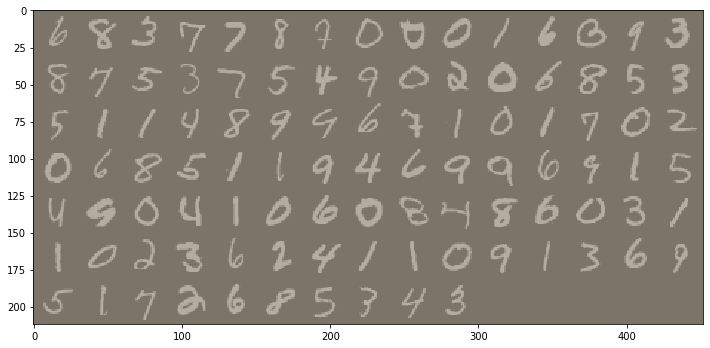

In [6]:
for images, labels in train_loader:
    break
im = make_grid(images,nrow=15)
inv_normalize = transforms.Normalize(
        mean= [-0.485/0.225,
              -0.456/0.224,
              -0.406/0.225],
        std= [1/0.225, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

plt.figure(figsize=(12,24))
plt.imshow(np.transpose(im_inv.numpy(),(1,2,0)))

### Build Network

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))  
        
        out = self.fc(out[:, -1, :])
        return out

model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)


### Visualization Network

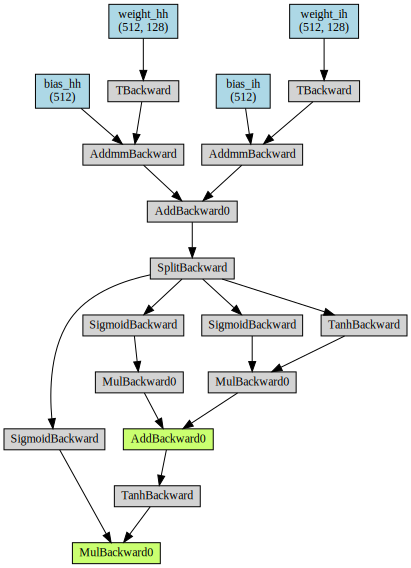

In [8]:
lstm_cell = nn.LSTMCell(128, 128)
x = torch.randn(1, 128)
make_dot(lstm_cell(x), params=dict(list(lstm_cell.named_parameters())))

### Loss and Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training

In [10]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/2], Step [100/600], Loss: 0.4902
Epoch [1/2], Step [200/600], Loss: 0.1198
Epoch [1/2], Step [300/600], Loss: 0.1424
Epoch [1/2], Step [400/600], Loss: 0.1876
Epoch [1/2], Step [500/600], Loss: 0.2158
Epoch [1/2], Step [600/600], Loss: 0.1211
Epoch [2/2], Step [100/600], Loss: 0.0918
Epoch [2/2], Step [200/600], Loss: 0.1831
Epoch [2/2], Step [300/600], Loss: 0.0317
Epoch [2/2], Step [400/600], Loss: 0.0432
Epoch [2/2], Step [500/600], Loss: 0.1109
Epoch [2/2], Step [600/600], Loss: 0.1165


### Testing

In [11]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 98.11 %


### Save Model


In [12]:
torch.save(model.state_dict(), 'model.ckpt')
